<h1 style='background:#C4F1E8; border:2; border-radius: 10px; font-size:250%; font-weight: bold; color:black'><center>Prédictions d'AVC</center></h1> 
 
<img src = "https://www.news-medical.net/image.axd?picture=2021%2F11%2Fshutterstock_1488035675-1.jpg" width = 500 height = 400/>

Pour la culture : 
L’accident vasculaire cérébral (AVC) est la conséquence de l’obstruction ou de la rupture d’un vaisseau transportant le sang dans le cerveau.

Il se traduit par un déficit neurologique d’installation soudaine, qui peut concerner la motricité, la sensibilité, le langage, ou la vision, pour ne citer que les manifestations les plus fréquentes, selon le siège de la lésion cérébrale (Quand y penser?)

Un autre terme utilisé est « attaque cérébrale ».
En anglais, l’AVC est désigné par le terme « stroke ».

<a id="title-five"></a>
<h1 style='background:#C4F1E8; border:2; border-radius: 10px; color:black'><center>Imports des librairies</center></h1>

In [34]:
# Session Spark
from pyspark import SparkContext
from pyspark.sql import SparkSession

# Pandas
import pyspark.pandas as pd

# Preprocessing
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder

# Model building
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Types
from pyspark.sql.types import DoubleType

# iplot
from matplotlib import pyplot

# éxécuter cette commande -> pip install cufflinks
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

**Creation de la Session Spark**

In [35]:
spark = SparkSession.builder.getOrCreate()

<a id="title-five"></a>
<h1 style='background:#C4F1E8; border:2; border-radius: 10px; color:black'><center>Lecture et analyse des données</center></h1>

L'analyse et la lecture de notre jeu de données se fera de manière séquentielle :

- Analyse des features et de leur type
- Détection de données erronées (valeurs null, inutiles, ...)
- L'ampleur des données
- Analyse des facteurs amenant à un AVC

In [36]:
# Lecture du jeu de données
df = spark.read.csv('./brain_stroke.csv', header = True, inferSchema = True).cache()

# Affichage de 5 entités
df.limit(10).toPandas()

# Affichage des features
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



**Analyse des features et de leur type**

- gender: "Male", "Female" or "Other"
- age: age of the patient
- hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- heart disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease 
- ever_married: "No" or "Yes"
- worktype: "children", "Govtjov", "Neverworked", "Private" or "Self-employed"
- Residencetype: "Rural" or "Urban"
- avgglucoselevel: average glucose level in blood
- bmi: body mass index
- smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
- stroke: 1 if the patient had a stroke or 0 if not

Après affichage du schéma de notre dataframe, nous nous rendons compte que les colonnes sont de différents type.

Dans le cadre de l'éxécution de notre future pipeline de Machine Learning, il sera vitale de transformer les valeurs non-numérique en valeur numérique.

**Détection de données erronées / inutiles**

In [37]:
df.select("gender").distinct().show()
print("Nombre d'entités avec le gender 'Other' : " + str(df.filter(df["gender"] == 'Other').count()))

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+

Nombre d'entités avec le gender 'Other' : 1


On remarque qu'il existe qu'une seule occurence du gender "other", on retirera donc durant la phase de preprocessing cette occurence afin que les données soient plus équilibrés.

On remarque également qu'il existe une valeur "unknown" pour notre feature "smoking_status".

In [38]:
df.select("smoking_status").distinct().toPandas()

,smoking_status
0,smokes
1,Unknown
2,never smoked
3,formerly smoked


Afin d'équilibrer notre jeu de donnée, il est impératif qu'une quantité exacte d"informations soit disponible pour chaque entité de notre data set, cela dans le but d'augmenter la précision de nos prédictions à venir.

On retirera donc durant la phase de preprocessing les entités avec une valeur de "smoking_status" à "unknown".

On remarque également que la feature "bmi" est de type string qui devraient en fait être des valeurs numériques, il va donc falloir les convertir en double.
Elle contient également des valeurs érronées (N/A) qui va falloir supprimer.

In [39]:
# Type de "bmi"
df.select("bmi").printSchema()

# Valeur erronné (N/A) :
df.select("bmi").show(2)

root
 |-- bmi: string (nullable = true)

+----+
| bmi|
+----+
|36.6|
| N/A|
+----+
only showing top 2 rows



La colonne "id" de notre dataframe sert uniquement d'attribut identifiante, elle n'est en rien un facteur de prédiction, on l'enlèvera donc durant la phase de clean data.

In [40]:
# Type de "bmi"
df.select("id").printSchema()

root
 |-- id: integer (nullable = true)



<a id="title-five"></a>
<h1 style='background:#C4F1E8; border:2; border-radius: 10px; color:black'><center>Visualisation des données</center></h1>

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Répartion des genres parmis les personnes ayant eu un AVC</center></h3>

array([<AxesSubplot: ylabel='count'>], dtype=object)

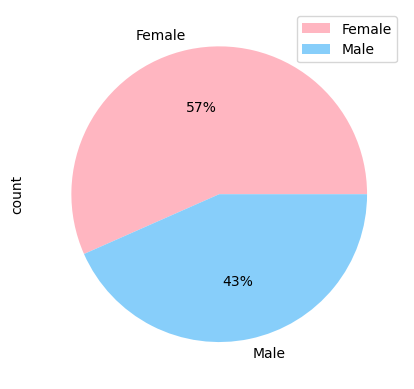

In [41]:
colors = ['lightpink', 'lightskyblue']

pandas_df = df.filter(df['stroke'] == 1).groupBy("stroke", "gender").count().orderBy("stroke").toPandas()
pandas_df.set_index("gender").plot.pie(y="count", colors=colors, autopct='%1.0f%%', subplots=True)

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Répartion des types d'emplois parmis les personnes ayant eu un AVC</center></h3>

array([<AxesSubplot: ylabel='count'>], dtype=object)

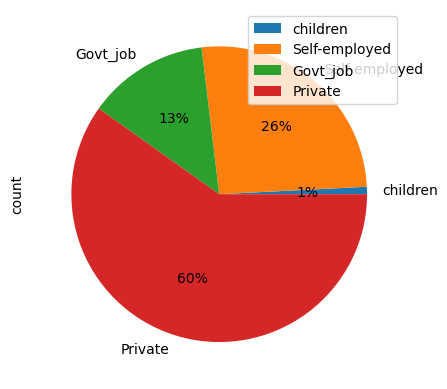

In [42]:
pandas_df = df.filter(df['stroke'] == 1).groupBy("stroke", "work_type").count().orderBy("stroke").toPandas()
pandas_df.set_index("work_type").plot.pie(y="count", subplots=True, autopct='%1.0f%%')

Pour la culture : Un cas de stress excessif (crise d'angoisse, ...) affecte le système cardiovasculaire, endommageant ainsi les artères au cas où on le laisse passer sans traitement. Le dommage vasculaire peut mener éventuellement à un AVC, qui constitue une urgence médicale provenant d'une artère dans le cerveau qui soit se rompe, soit se bouche.

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Personnes mariées parmis les personnes ayant eu un AVC</center></h3>

array([<AxesSubplot: ylabel='count'>], dtype=object)

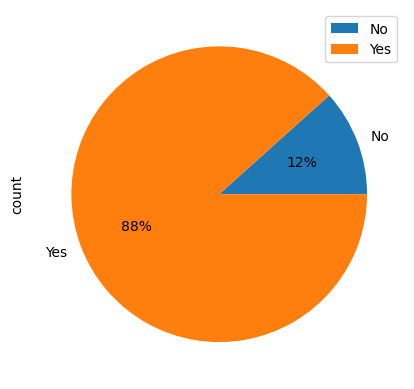

In [43]:
pandas_df = df.filter(df['stroke'] == 1).groupBy("stroke", "ever_married").count().orderBy("stroke").toPandas()
pandas_df.set_index("ever_married").plot.pie(y="count", subplots=True, autopct='%1.0f%%')

![ChessUrl](https://media1.giphy.com/media/jIIduCs5nkq2i2emoS/giphy.gif)

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Répartition des fumeurs / non fumeurs</center></h3>

array([<AxesSubplot: ylabel='count'>], dtype=object)

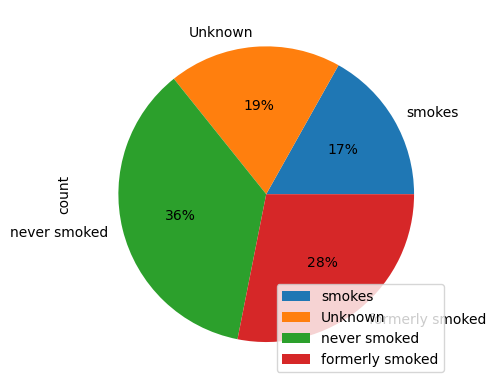

In [44]:
pandas_df = df.filter(df['stroke'] == 1).groupBy("stroke", "smoking_status").count().orderBy("stroke").toPandas()
pandas_df.set_index("smoking_status").plot.pie(y="count", subplots=True, autopct='%1.0f%%')

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Répartition des âges entre hommes et femmes</center></h3>

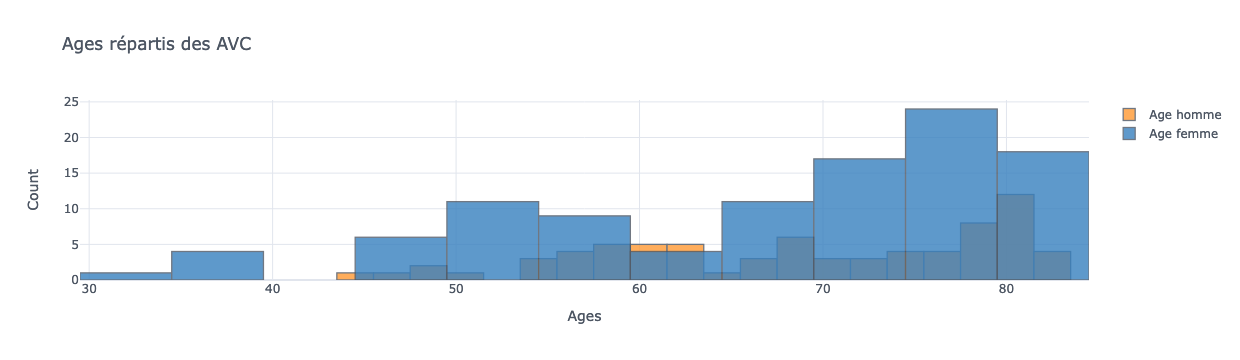

In [55]:
stroke = df.toPandas().loc[df.toPandas()['stroke'] == 1].reset_index()

stroke["Age homme"] = stroke[stroke["gender"] == "Male"]["age"]
stroke["Age femme"] = stroke[stroke["gender"] == "Female"]["age"]

stroke[["Age homme","Age femme"]].iplot(
   kind="histogram", bins=20, theme="white", title="Ages répartis des AVC",
   xTitle='Ages', yTitle='Count'
)

<a id="title-five"></a>
<h1 style='background:#C4F1E8; border:2; border-radius: 10px; color:black'><center>DATA PREPROCESSING</center></h1>

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Clean data</center></h3>

Comme mentionée plus haut durant la phase d'analyse des données, il est primordiale de supprimer les données erronnés/inutiles.

Egalement, il sera impératif de transformer nos données en données numériques.

Pour cela, il nous sera utile d'utiliser : 

- StringIndexer : il nous servira à convertir les valeurs string binaire (true/false, yes/no, ...) en valeur numérique (0 et 1). Par exemple, la feature "ever_married", les valeurs par défauts sont "yes" et "no", elles seront transformées en 0 et 1.
- OneHotEncoder : il nous servira à construire des matrices binaires pour nos features possédant plusieurs modalités possible. Par exemple, la feature "work_type" peut avoir plusieurs valeurs (Private, Self-employed, Private, Children)
- Vecteur assembleur : il nous servira a obtenir pour chaque entité l'ensemble de leur feature stocké dans une colonne.

Nous entamerons la transformation de notre dataframe en sous-étapes éxécuté dans une pipeline machine learning.

In [46]:
df = df.filter(df["gender"] != "Other")

# Affichage des valeurs possible de "gender" après suppression :
df.select("gender").distinct().toPandas()

,gender
0,Female
1,Male


In [47]:
df = df.filter(df["smoking_status"] != "Unknown")

# Affichage des valeurs possible de "smoking_status" après suppression :
df.select("smoking_status").distinct().toPandas()

,smoking_status
0,smokes
1,never smoked
2,formerly smoked


In [48]:
# Retire les "not applicable" bmi
df = df.filter(df["bmi"] != "N/A")

# Convertir BMI en type double
df = df.withColumn("bmi", df.bmi.cast(DoubleType()))
df.select("bmi").printSchema()

root
 |-- bmi: double (nullable = true)



In [49]:
# On supprime la colonne "id"
df = df.drop("id")

In [50]:
# Vérification de la non-présence de valeurs null
df.toPandas().isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

<a id="title-five"></a>
<h1 style='background:#C4F1E8; border:2; border-radius: 10px; color:black'><center>Construction des modèles</center></h1>

In [59]:
categorical_features = ['gender', 'ever_married', 'Residence_type', 'work_type', 'smoking_status']
numeric_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

categorical_features_idx = [f + '_idx' for f in categorical_features]
string_indexer = StringIndexer(inputCols=var1, handleInvalid='skip', outputCols=categorical_features_idx)

categorical_features_enc = ['work_type_enc', 'Residence_type_enc', 'smoking_status_enc']
ont_hot_encoder = OneHotEncoder(dropLast=False, inputCols=t, outputCols=categorical_features_enc)

columns = ['gender_idx', 'ever_married_idx', 'work_type_enc', 'Residence_type_enc', 'smoking_status_enc', 'bmi', 'avg_glucose_level', 'age', 'hypertension', 'heart_disease']
vector_assembler = VectorAssembler(inputCols=columns, outputCol='features', handleInvalid="skip")

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Decision Tree</center></h3>

In [60]:
train, test = df.randomSplit([0.7, 0.3])

from pyspark.ml.classification import DecisionTreeClassifier
tree_classifier = DecisionTreeClassifier(labelCol='stroke', featuresCol='features')

model = Pipeline(stages= [string_indexer]+[ont_hot_encoder]+[vector_assembler]+[tree_classifier]).fit(train)
pred_tree = model.transform(test)
pred_tree.select('prediction', 'stroke', 'features').show()

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='stroke', predictionCol='prediction', metricName='accuracy')
accuracy_tree = evaluator.evaluate(pred_tree)

print("Précision de l'arbre de décision : = %g"% (accuracy_tree))
print("Erreur de l'arbre de décision : %g " % (1.0 - accuracy_tree))

+----------+------+--------------------+
|prediction|stroke|            features|
+----------+------+--------------------+
|       0.0|     0|(17,[1,5,7,10,12,...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,10,12,...|
|       0.0|     0|(17,[1,6,7,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,2,7,10,12,...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,3,8,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,6,8,9,12,1...|
|       0.0|     0|(17,[1,6,7,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
+----------+------+--------------------+
only showing top

<h3 style='background:#F1C4EF; border:1; border-radius:10px; color:black'><center>Random Forest</center></h3>

In [61]:
from pyspark.ml.classification import RandomForestClassifier
random_forest = RandomForestClassifier(featuresCol = 'features', labelCol = 'stroke')

random_forest_model = Pipeline(stages=[stage_1]+[stage_2]+[stage_3]+[random_forest]).fit(train)
predictions_random_forest = random_forest_model.transform(test)
predictions_random_forest.select('prediction', 'stroke', 'features').show()

evaluator = BinaryClassificationEvaluator(labelCol='stroke')
accuracy_rf = evaluator.evaluate(predictions_random_forest)

print("Précision du random forest : = %g"% (accuracy_rf))
print("Erreur du random forest : %g " % (1.0 - accuracy_rf))

+----------+------+--------------------+
|prediction|stroke|            features|
+----------+------+--------------------+
|       0.0|     0|(17,[1,5,7,10,12,...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,10,12,...|
|       0.0|     0|(17,[1,6,7,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,2,7,10,12,...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,3,8,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,5,7,9,12,1...|
|       0.0|     0|(17,[1,6,8,9,12,1...|
|       0.0|     0|(17,[1,6,7,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,2,7,9,12,1...|
|       0.0|     0|(17,[1,2,8,9,12,1...|
+----------+------+--------------------+
only showing top